Pour une lecture améliorée, ce notebook est idéalement lu avec une extension qui gère les niveaux des titres Markdown.  
Par exemple avec l'extension 'Table of Contents' du module 'Nbextensions' de Jupyter.

# Mise en place du notebook

## Import des modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress as reg_lin
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import QuantileTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LinearRegression
from sklearn import set_config
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.compose import TransformedTargetRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

## Gestion des paramètres d'affichage de Jupyter

In [2]:
# pour gérer l'affichage des dataframes pandas
pd.options.display.max_rows = 100
pd.options.display.max_columns = 200

# pour gérer l'affichage des arrays numpy
# 230 sur ma config bureau, 165 sur ma config portable
np.set_printoptions(linewidth=165)

# pour afficher les gros fichiers sur toute la largeur de l'écran
from IPython.core.display import HTML
HTML("<style>.container { width:95% }</style>")

## Rappel de la fonction scatter_plot() du notebook d'exploration

In [3]:
def scatter_plot(ser_x,
                 ser_y,
                 min_x=None,
                 max_x=None,
                 min_y=None,
                 max_y=None,
                 alpha=1.0,
                 unite_x=None,
                 unite_y=None,
                 ligne_diagonale = False):
    """ Retourne un scatter plot pour deux séries
    Args :
    - ser_x : série en abcisse.
    - ser_y : série en ordonnée.
    - min_x : valeur min représentée en abcisse.
    - max_x : valeur max représentée en abcisse.
    - min_y : valeur min représentée en ordonnée.
    - max_y : valeur max représentée en ordonnée.
    - alpha : transparence de chaque point.  
    - unite_x : string indiquant l'unité de la série en abcisse.  
    - unite_y : string indiquant l'unité de la série en ordonnée.        
    Returns : 
    - scatter plot + sa régression linéaire
    """
    
    # Calcul des arguments min_x, max_x, min_y, max_y s'ils sont None :
    if min_x is None:
        min_x = ser_x.min()
    if max_x is None:
        max_x = ser_x.max()
    if min_y is None:
        min_y = ser_y.min()
    if max_y is None:
        max_y = ser_y.max()
    
    # filtration des valeurs extrêmes. On exclue les valeurs à l'extérieur de l'intervalle [min_x, max_x], considérées comme aberrantes.
    largeur_x = max_x - min_x
    largeur_y = max_y - min_y

    def f_bool(x, min, max):
        if np.isnan(x):
            return False
        elif x < min:
            return False
        elif x > max:
            return False
        else:
            return True

    ser_x_bool = ser_x.apply(lambda x: f_bool(x, min_x, max_x)
                             )  # vaut True pour les valeurs non extrêmes
    ser_y_bool = ser_y.apply(lambda y: f_bool(y, min_y, max_y))
    ser_xy_bool = ser_x_bool & ser_y_bool  # vaut True pour les valeurs non extrêmes de ser_x et de ser_y, sinon vaut False
    # ser_x et ser_y sont les séries tracées
    ser_x = ser_x[ser_xy_bool]
    ser_y = ser_y[ser_xy_bool]
    total_count = ser_xy_bool.sum()

    # mise en place du plot
    plt.style.use('seaborn')
    plt.figure(edgecolor='black', linewidth=4)
    if ligne_diagonale:
        plt.axline([0, 0], [1, 1], c="white", linewidth=1)
    
    # plotting scatter plot
    plt.scatter(
        ser_x, ser_y, s=2,
        alpha=alpha)  # la valeur mini de alpha autorisée par pyplot est 0.002
    plt.xlabel(ser_x.name)
    plt.ylabel(ser_y.name)
    plt.title(label='Diagramme de dispersion (Effectif total = ' +
              str(int(total_count)) + ')')
    plt.ylim(min_y - largeur_y / 20, max_y + largeur_y / 20)
    label_x = ser_x.name if unite_x is None else ser_x.name + f" ({unite_x})"
    plt.xlabel(label_x)
    label_y = ser_y.name if unite_y is None else ser_y.name + f" ({unite_y})"
    plt.ylabel(label_y)

    # régression linéaire
    slope, intercept, r, p, std_err = reg_lin(ser_x, ser_y)
    plt.axline((0, intercept), slope=slope, ls="--", c="red", linewidth=0.6)

    plt.annotate(
        text="Régression linéaire : y = {0:0.4f}*x + {1:0.4f}, R²={2:0.2f}".
        format(slope, intercept, r * r),
        xy=(min_x + largeur_x / 20, max_y - largeur_y / 20),
        color='red',
        size=10)
    
    plt.show()

# Chargement du pickle du df nettoyé

In [4]:
df1 = pd.read_pickle('df_après_nettoyage_Projet_élec.pkl')

# Feature engineering

## Surface au sol

Les pertes énergétiques des bâtiments avec une forte surface de contact avec l'extérieur seront plus importantes que celles des bâtiments avec une faible surface de contact.  
Sur la base des données disponibles, on ne pourra pas calculer cette surface.  
Toutefois on peut calculer la surface au sol des bâtiments. C'est un bon proxy de la surface de contact totale pour les bâtiments à peu d'étages.

Surface_au_sol(sf) = PropertyGFABuilding(s) / NumberofFloors 


In [5]:
df1['Surface_au_sol(sf)'] = df1['PropertyGFABuilding(s)'].copy() / df1['NumberofFloors'].copy()

In [6]:
df1['Surface_au_sol(sf)'].describe()

count    1.668000e+03
mean              inf
std               NaN
min      2.216970e+02
25%      1.235629e+04
50%      2.119500e+04
75%      3.438105e+04
max               inf
Name: Surface_au_sol(sf), dtype: float64

Il y a des valeurs np.inf lorsque NumberofFloors vaut 0 => on les transforme en NaN.

In [7]:
df1['Surface_au_sol(sf)'] = df1['Surface_au_sol(sf)'].apply(lambda x : np.NaN if x == np.inf else x)

In [8]:
df1['Surface_au_sol(sf)'].describe()

count    1.652000e+03
mean     3.177939e+04
std      4.708716e+04
min      2.216970e+02
25%      1.229850e+04
50%      2.102900e+04
75%      3.361888e+04
max      1.100000e+06
Name: Surface_au_sol(sf), dtype: float64

## Variables prédites

La demande de Douglas est de prédire les variables :  
    - 'SiteEnergyUse(kBtu)',  
    - 'TotalGHGEmissions',  
cependant, nous travaillerons plutôt sur la prévision de :  
    - 'SiteEUI(kBtu/sf)',  
    - 'GHGEmissionsIntensity',  
qui ont une relation plus "linéaire" avec les autres variables descriptives. 

# Variables retenues pour la modélisation

In [9]:
list(df1.columns)

['OSEBuildingID',
 'BuildingType',
 'PrimaryPropertyType',
 'ZipCode',
 'CouncilDistrictCode',
 'Neighborhood',
 'Latitude',
 'Longitude',
 'YearBuilt',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'PropertyGFAParking',
 'PropertyGFABuilding(s)',
 'LargestPropertyUseType',
 'LargestPropertyUseTypeGFA',
 'SecondLargestPropertyUseType',
 'SecondLargestPropertyUseTypeGFA',
 'ThirdLargestPropertyUseType',
 'ThirdLargestPropertyUseTypeGFA',
 'ENERGYSTARScore',
 'SiteEUI(kBtu/sf)',
 'SiteEUIWN(kBtu/sf)',
 'SourceEUI(kBtu/sf)',
 'SourceEUIWN(kBtu/sf)',
 'SiteEnergyUse(kBtu)',
 'SiteEnergyUseWN(kBtu)',
 'SteamUse(kBtu)',
 'Electricity(kWh)',
 'Electricity(kBtu)',
 'NaturalGas(therms)',
 'NaturalGas(kBtu)',
 'TotalGHGEmissions',
 'GHGEmissionsIntensity',
 'Surface_au_sol(sf)']

La demande de Douglas est de prédire les variables :  
    - 'SiteEnergyUse(kBtu)',  
    - 'TotalGHGEmissions',  
cependant, nous travaillerons plutôt sur la prévision de :  
    - 'SiteEUI(kBtu/sf)',  
    - 'GHGEmissionsIntensity',  
qui ont un lien plus "linéaire" avec les autres variables descriptives. 

In [10]:
liste_variables_pour_modelisation =[
    'BuildingType', 
    'PrimaryPropertyType', 
    'ZipCode',
    'CouncilDistrictCode', 
    'Neighborhood', 
    'Latitude', 
    'Longitude',
    'YearBuilt', 
    'NumberofBuildings', 
    'NumberofFloors', 
#     'PropertyGFATotal',    exclu car donnée extensive
#     'PropertyGFAParking',    exclu car donnée extensive
#     'PropertyGFABuilding(s)',  exclu car donnée extensive
    'LargestPropertyUseType',
#     'LargestPropertyUseTypeGFA',  exclu car donnée extensive
    'SecondLargestPropertyUseType', 
#     'SecondLargestPropertyUseTypeGFA',  exclu car donnée extensive
    'ThirdLargestPropertyUseType', 
#     'ThirdLargestPropertyUseTypeGFA',  exclu car donnée extensive
#     'ENERGYSTARScore', exclu sinon data leak
#     'SiteEUI(kBtu/sf)', variable à prédire
#     'SiteEUIWN(kBtu/sf)', exclu sinon data leak
#     'SourceEUI(kBtu/sf)', exclu sinon data leak
#     'SourceEUIWN(kBtu/sf)', exclu sinon data leak
#     'SiteEnergyUse(kBtu)', exclu sinon data leak
#     'SiteEnergyUseWN(kBtu)', exclu sinon data leak
#     'SteamUse(kBtu)', exclu sinon data leak
#     'Electricity(kWh)',exclu sinon data leak
#     'Electricity(kBtu)', exclu sinon data leak
#     'NaturalGas(therms)', exclu sinon data leak
#     'NaturalGas(kBtu)',exclu sinon data leak
#     'TotalGHGEmissions', exclu sinon data leak
#     'GHGEmissionsIntensity', variable à prédire
    'Surface_au_sol(sf)']

# Train test split 

POUR LE NOTEBOOK FINAL IL FAUDRA FAIRE LE SPLIT PLUS TOT (avant le nettoyage)  
IL FAUDRA FAIRE LE MEME NETTOYAGE SUR LES JEUX TRAIN ET TEST

POUR L'INSTANT ON NE TRAVAILLE QU'A LA PREDICTION DE SiteEUI(kBtu/sf)

In [11]:
# Suppression des lignes pour lesquelles la variable 'SiteEUI(kBtu/sf)'     ?? que se passe-t-il si je ne le fais pas ??
df1 = df1.dropna(subset=['SiteEUI(kBtu/sf)']).copy()

##### Variables à prédire :

In [12]:
y1_EUI = df1[['SiteEUI(kBtu/sf)']].copy()
# y1_GHGEI = df1['GHGEmissionsIntensity'].copy()     Pour l'instant on se contente de prédire y1_EUI.

##### Variables explicatives :

In [13]:
X1 = df1[liste_variables_pour_modelisation].copy()

##### Split :

In [14]:
X_train_EUI, X_test_EUI, y_train_EUI, y_test_EUI = train_test_split(X1, y1_EUI, test_size=0.2, random_state=0)

# Imputations

## Définition des variables quantitatives et qualitatives

In [15]:
list(X_train_EUI.columns)

['BuildingType',
 'PrimaryPropertyType',
 'ZipCode',
 'CouncilDistrictCode',
 'Neighborhood',
 'Latitude',
 'Longitude',
 'YearBuilt',
 'NumberofBuildings',
 'NumberofFloors',
 'LargestPropertyUseType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType',
 'Surface_au_sol(sf)']

In [16]:
liste_variables_qualitatives = [
 'BuildingType',
 'PrimaryPropertyType',
 'ZipCode',
 'CouncilDistrictCode',
 'Neighborhood',
#  'Latitude',
#  'Longitude',
#  'YearBuilt',
#  'NumberofBuildings',
#  'NumberofFloors',
 'LargestPropertyUseType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType',
#  'Surface_au_sol(sf)'
]

In [17]:
liste_variables_quantitatives = [
#  'BuildingType',
#  'PrimaryPropertyType',
#  'ZipCode',
#  'CouncilDistrictCode',
#  'Neighborhood',
 'Latitude',
 'Longitude',
 'YearBuilt',
 'NumberofBuildings',
 'NumberofFloors',
#  'LargestPropertyUseType',
#  'SecondLargestPropertyUseType',
#  'ThirdLargestPropertyUseType',
 'Surface_au_sol(sf)'
]

In [18]:
X_train_EUI

,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,Surface_au_sol(sf)
3162,NonResidential,Large Office,98109.0,7,LAKE UNION,47.62037,-122.33627,2012,1.0,11,Office,Parking,Other,47856.636364
953,NonResidential,Worship Facility,98115.0,4,NORTHEAST,47.68752,-122.29852,2000,1.0,2,Worship Facility,NaN,NaN,15693.000000
2637,NonResidential,Hotel,98108.0,2,GREATER DUWAMISH,47.54774,-122.32091,1992,1.0,3,Hotel,NaN,NaN,7484.000000
29,NonResidential,Hotel,98121.0,7,DOWNTOWN,47.61558,-122.34186,1978,1.0,5,Hotel,NaN,NaN,10442.000000
1126,NonResidential,Small- and Mid-Sized Office,98108.0,2,GREATER DUWAMISH,47.55316,-122.32616,1982,1.0,2,Office,Non-Refrigerated Warehouse,NaN,20014.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,NonResidential,Retail Store,98134.0,2,GREATER DUWAMISH,47.56535,-122.34054,1953,1.0,1,Retail Store,Non-Refrigerated Warehouse,NaN,39900.000000
1192,NonResidential,Small- and Mid-Sized Office,98133.0,5,NORTHWEST,47.72004,-122.34418,1951,1.0,2,Office,Non-Refrigerated Warehouse,NaN,19907.500000
2120,NonResidential,Warehouse,98108.0,1,GREATER DUWAMISH,47.53160,-122.33300,1970,1.0,1,Non-Refrigerated Warehouse,NaN,NaN,44000.000000
580,NonResidential,University,98122.0,3,CENTRAL,47.60940,-122.31506,1916,1.0,2,College/University,Parking,NaN,30061.000000


In [19]:
X_train_EUI[liste_variables_quantitatives].describe()

,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,Surface_au_sol(sf)
count,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1.307000e+03
mean,47.616247,-122.332559,1962.246212,1.156818,4.200758,3.116310e+04
std,0.048964,0.024321,32.540533,3.187654,6.912526,4.779553e+04
min,47.510180,-122.411820,1900.000000,0.000000,0.000000,2.216970e+02
25%,47.584275,-122.342598,1930.000000,1.000000,1.000000,1.247250e+04
50%,47.612380,-122.332890,1966.000000,1.000000,2.000000,2.097500e+04
75%,47.650627,-122.321848,1989.000000,1.000000,4.000000,3.254500e+04
max,47.733870,-122.258640,2015.000000,111.000000,99.000000,1.100000e+06


In [20]:
X_train_EUI[liste_variables_quantitatives]

,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,Surface_au_sol(sf)
3162,47.62037,-122.33627,2012,1.0,11,47856.636364
953,47.68752,-122.29852,2000,1.0,2,15693.000000
2637,47.54774,-122.32091,1992,1.0,3,7484.000000
29,47.61558,-122.34186,1978,1.0,5,10442.000000
1126,47.55316,-122.32616,1982,1.0,2,20014.500000
...,...,...,...,...,...,...
1045,47.56535,-122.34054,1953,1.0,1,39900.000000
1192,47.72004,-122.34418,1951,1.0,2,19907.500000
2120,47.53160,-122.33300,1970,1.0,1,44000.000000
580,47.60940,-122.31506,1916,1.0,2,30061.000000


## Imputation des variables quantitatives

In [21]:
imputer_quanti = SimpleImputer(strategy="median")

In [22]:
X_train_EUI[liste_variables_quantitatives] = imputer_quanti.fit_transform(X_train_EUI[liste_variables_quantitatives])

<ipython-input-22-f1c96264e1c9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_EUI[liste_variables_quantitatives] = imputer_quanti.fit_transform(X_train_EUI[liste_variables_quantitatives])
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [23]:
X_train_EUI[liste_variables_quantitatives].describe()

,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,Surface_au_sol(sf)
count,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1.320000e+03
mean,47.616247,-122.332559,1962.246212,1.156818,4.200758,3.106277e+04
std,0.048964,0.024321,32.540533,3.187654,6.912526,4.757006e+04
min,47.510180,-122.411820,1900.000000,0.000000,0.000000,2.216970e+02
25%,47.584275,-122.342598,1930.000000,1.000000,1.000000,1.265917e+04
50%,47.612380,-122.332890,1966.000000,1.000000,2.000000,2.097500e+04
75%,47.650627,-122.321848,1989.000000,1.000000,4.000000,3.236550e+04
max,47.733870,-122.258640,2015.000000,111.000000,99.000000,1.100000e+06


In [24]:
imputer_quanti.statistics_

array([ 4.7612380e+01, -1.2233289e+02,  1.9660000e+03,  1.0000000e+00,  2.0000000e+00,  2.0975000e+04])

## Imputation des variables qualitatives

In [25]:
X_train_EUI

,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,Surface_au_sol(sf)
3162,NonResidential,Large Office,98109.0,7,LAKE UNION,47.62037,-122.33627,2012.0,1.0,11.0,Office,Parking,Other,47856.636364
953,NonResidential,Worship Facility,98115.0,4,NORTHEAST,47.68752,-122.29852,2000.0,1.0,2.0,Worship Facility,NaN,NaN,15693.000000
2637,NonResidential,Hotel,98108.0,2,GREATER DUWAMISH,47.54774,-122.32091,1992.0,1.0,3.0,Hotel,NaN,NaN,7484.000000
29,NonResidential,Hotel,98121.0,7,DOWNTOWN,47.61558,-122.34186,1978.0,1.0,5.0,Hotel,NaN,NaN,10442.000000
1126,NonResidential,Small- and Mid-Sized Office,98108.0,2,GREATER DUWAMISH,47.55316,-122.32616,1982.0,1.0,2.0,Office,Non-Refrigerated Warehouse,NaN,20014.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,NonResidential,Retail Store,98134.0,2,GREATER DUWAMISH,47.56535,-122.34054,1953.0,1.0,1.0,Retail Store,Non-Refrigerated Warehouse,NaN,39900.000000
1192,NonResidential,Small- and Mid-Sized Office,98133.0,5,NORTHWEST,47.72004,-122.34418,1951.0,1.0,2.0,Office,Non-Refrigerated Warehouse,NaN,19907.500000
2120,NonResidential,Warehouse,98108.0,1,GREATER DUWAMISH,47.53160,-122.33300,1970.0,1.0,1.0,Non-Refrigerated Warehouse,NaN,NaN,44000.000000
580,NonResidential,University,98122.0,3,CENTRAL,47.60940,-122.31506,1916.0,1.0,2.0,College/University,Parking,NaN,30061.000000


In [26]:
X_train_EUI[liste_variables_qualitatives].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1320 entries, 3162 to 839
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   BuildingType                  1320 non-null   object 
 1   PrimaryPropertyType           1320 non-null   object 
 2   ZipCode                       1307 non-null   float64
 3   CouncilDistrictCode           1320 non-null   int64  
 4   Neighborhood                  1320 non-null   object 
 5   LargestPropertyUseType        1316 non-null   object 
 6   SecondLargestPropertyUseType  686 non-null    object 
 7   ThirdLargestPropertyUseType   292 non-null    object 
dtypes: float64(1), int64(1), object(6)
memory usage: 92.8+ KB


In [27]:
imputer_quali_ZC = SimpleImputer(strategy='constant', fill_value=None)     # fill_value will be 0 when imputing numerical data and “missing_value” for strings or object data types
imputer_quali_CDC = SimpleImputer(strategy='constant', fill_value=None) 
imputer_quali_autre = SimpleImputer(strategy='constant', fill_value=None) 

X_train_EUI[['ZipCode']] = imputer_quali_ZC.fit_transform(X_train_EUI[['ZipCode']])
X_train_EUI[['CouncilDistrictCode']] = imputer_quali_CDC.fit_transform(X_train_EUI[['CouncilDistrictCode']])
X_train_EUI[['BuildingType',
 'PrimaryPropertyType',
 'Neighborhood',
 'LargestPropertyUseType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType']
] = imputer_quali_CDC.fit_transform(X_train_EUI[['BuildingType',
 'PrimaryPropertyType',
 'Neighborhood',
 'LargestPropertyUseType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType']])

<ipython-input-27-7f652f4f67b0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_EUI[['ZipCode']] = imputer_quali_ZC.fit_transform(X_train_EUI[['ZipCode']])
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-27-7f652f4f67b0>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

In [28]:
X_train_EUI[X_train_EUI.isnull().any(axis=1)]

,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,Surface_au_sol(sf)


# One hot encoding (variables qualitatives)

In [29]:
liste_variables_qualitatives

['BuildingType',
 'PrimaryPropertyType',
 'ZipCode',
 'CouncilDistrictCode',
 'Neighborhood',
 'LargestPropertyUseType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType']

In [30]:
# sklearn force à séparer l'encodage des variables strings et variables numériques
# encoder_num = OneHotEncoder(handle_unknown='ignore')
# encoder_str = OneHotEncoder(handle_unknown='ignore')
encoder = OneHotEncoder(handle_unknown='ignore')

# X_train_EUI_1hot_num = encoder_num.fit_transform(X_train_EUI[['ZipCode', 'CouncilDistrictCode']])
# X_train_EUI_1hot_str = encoder_str.fit_transform(X_train_EUI[['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'LargestPropertyUseType',  'SecondLargestPropertyUseType',  'ThirdLargestPropertyUseType']])
X_train_EUI_1hot = encoder.fit_transform(X_train_EUI[liste_variables_qualitatives])

# display(X_train_EUI_1hot_num)
# display(X_train_EUI_1hot_str)
display(X_train_EUI_1hot)

<1320x235 sparse matrix of type '<class 'numpy.float64'>'
	with 10560 stored elements in Compressed Sparse Row format>

In [31]:
encoder.categories_

[array(['Campus', 'NonResidential', 'Nonresidential COS', 'SPS-District K-12'], dtype=object),
 array(['Distribution Center', 'Hospital', 'Hotel', 'K-12 School', 'Laboratory', 'Large Office', 'Low-Rise Multifamily', 'Medical Office', 'Mixed Use Property',
        'Office', 'Other', 'Refrigerated Warehouse', 'Residence Hall', 'Restaurant', 'Retail Store', 'Self-Storage Facility', 'Senior Care Community',
        'Small- and Mid-Sized Office', 'Supermarket / Grocery Store', 'University', 'Warehouse', 'Worship Facility'], dtype=object),
 array([    0., 98011., 98013., 98020., 98033., 98053., 98070., 98101., 98102., 98103., 98104., 98105., 98106., 98107., 98108., 98109., 98111., 98112., 98113.,
        98114., 98115., 98116., 98117., 98118., 98119., 98121., 98122., 98124., 98125., 98126., 98133., 98134., 98136., 98144., 98146., 98154., 98155., 98164.,
        98165., 98168., 98177., 98178., 98181., 98185., 98195., 98199.]),
 array([1, 2, 3, 4, 5, 6, 7], dtype=int64),
 array(['BALLARD', 'Ba

# Recalibrage (variables quantitatives)

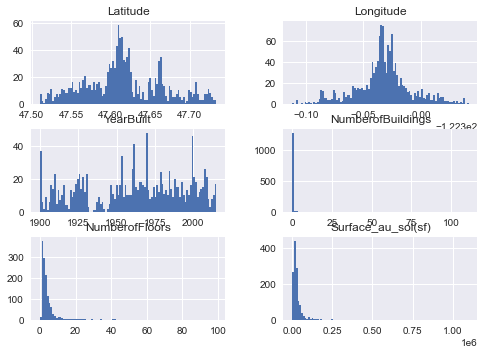

In [32]:
# Tracé des variables quantitatives avant recalibrage
plt.style.use('seaborn')
X_train_EUI[liste_variables_quantitatives].hist(bins=100)#, figsize=(22,15))
plt.show()

In [33]:
qt = QuantileTransformer(n_quantiles=1000, random_state=0, output_distribution='normal')
X_train_EUI_qt = qt.fit_transform(X_train_EUI[liste_variables_quantitatives])

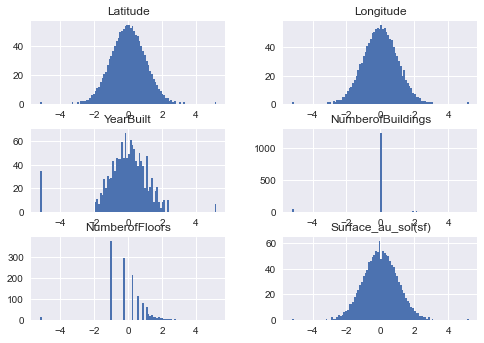

In [34]:
# Tracé des variables quantitatives après recalibrage
df_qt = pd.DataFrame(X_train_EUI_qt, columns=liste_variables_quantitatives)

plt.style.use('seaborn')
df_qt.hist(bins=100)
plt.show()

# Pipeline (imputation, one hot encoding, recalibrage)

On combine les opérations décrites dans les chapitres précédents (imputation, one hot encoding, recalibrage) en un workflow automatisé.

In [35]:
# On recrée les jeux de train/test avec split
X1 = df1[liste_variables_pour_modelisation].copy()
X_train_EUI, X_test_EUI, y_train_EUI, y_test_EUI = train_test_split(X1, y1_EUI, test_size=0.2, random_state=0)

## Pipeline variables quantitatives

In [36]:
pipeline_quanti = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('scaler', QuantileTransformer(n_quantiles=1000, random_state=0, output_distribution='normal')),
    ])

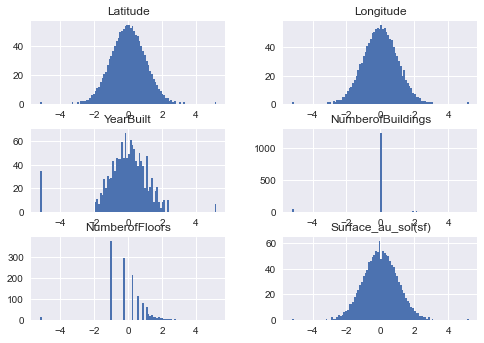

In [37]:
# test du pipeline
X_train_EUI_quanti = pipeline_quanti.fit_transform(X_train_EUI[liste_variables_quantitatives])

# Tracé des variables quantitatives après pipeline
df_quanti = pd.DataFrame(X_train_EUI_quanti, columns=liste_variables_quantitatives)
plt.style.use('seaborn')
df_quanti.hist(bins=100)
plt.show()

OK, on retrouve les mêmes histogrammes avec un pipeline.

## Pipeline variables qualitatives

L'imputer SimpleImputer de sklearn a un défaut de conception : lorsque le dataframe contient des données de type différents (string et numérique), les colonnes numériques sont imputées avec des strings.
Ce qui fait ensuiter bugger OneHotEncoder.
Il faut donc créer un imputeur maison et en faire un transformateur compatible avec un pipeline.

In [38]:
def Remplace_NA(df=None):
    """ Pour chaque variable, on remplace les valeurs null par une même valeur :  
      * 'ND' pour les strings,  
      * -1 pour les variables numériques.
    Args :
    - df : un dataframe.
    Returns : 
    - dff : le dataframe sans valeur null.
    """
    dff = df.copy()
    for var in liste_variables_qualitatives:
        if dff[var].dtype == 'object' :
            dff[var] = dff[var].fillna(value='ND', inplace=False)
        else :
            dff[var] = dff[var].fillna(value=-1, inplace=False)
    return dff
            
MonImputeur = FunctionTransformer(Remplace_NA)

In [39]:
pipeline_quali = Pipeline([
        ('imputer', MonImputeur),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ])

# pipeline_quali.fit_transform(X_train_EUI[liste_variables_qualitatives])

## Union des pipelines (ColumnTransformer)

In [40]:
full_pipeline = ColumnTransformer([
        ("quanti", pipeline_quanti, liste_variables_quantitatives),
        ("quali", pipeline_quali, liste_variables_qualitatives)
    ])

X_train_EUI_prepared = full_pipeline.fit_transform(X_train_EUI)

X_train_EUI_prepared

<1320x241 sparse matrix of type '<class 'numpy.float64'>'
	with 18466 stored elements in Compressed Sparse Row format>

In [41]:
# visualisation du pipeline
set_config(display='diagram')
full_pipeline

ColumnTransformer(transformers=[('quanti',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler',
                                                  QuantileTransformer(output_distribution='normal',
                                                                      random_state=0))]),
                                 ['Latitude', 'Longitude', 'YearBuilt',
                                  'NumberofBuildings', 'NumberofFloors',
                                  'Surface_au_sol(sf)']),
                                ('quali',
                                 Pipeline(steps=[('imputer',
                                                  FunctionTransformer(func=<function Remplace_NA at 0x000000000BA184C0>)),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['BuildingType', 'PrimaryPropertyType',
                                  'ZipCode', 'CouncilDistrictCode',
                                  'Neighborhood', 'LargestPropertyUseType',
                                  'SecondLargestPropertyUseType',
                                  'ThirdLargestPropertyUseType'])])

# Régressions linéaires

## Régression linéaire simple

In [42]:
lin_reg = LinearRegression()

# Entrainement
lin_reg.fit(X_train_EUI_prepared, y_train_EUI)

LinearRegression()

In [43]:
# Test de quelques valeurs prédites
some_data = X_train_EUI.iloc[:100]
some_labels = y_train_EUI.iloc[:100].copy()
some_data_prepared = full_pipeline.transform(some_data)
some_data_predicted = lin_reg.predict(some_data_prepared)

some_labels['Prédictions'] = some_data_predicted
some_labels.head(10)

,SiteEUI(kBtu/sf),Prédictions
3162,42.799999,59.230377
953,37.599998,28.567644
2637,55.400002,74.624596
29,92.900002,75.240507
1126,36.799999,27.209902
773,45.500000,78.520747
305,89.300003,193.994349
2928,35.000000,75.721566
579,104.099998,92.325513
713,40.200001,21.662289


### Metrics

##### RMSE :

In [44]:
EUI_predictions = lin_reg.predict(X_train_EUI_prepared)
lin_mse = mean_squared_error(y_train_EUI, EUI_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

44.14250276888454

##### R²

In [45]:
#R² par la méthode score() du transformateur
lin_reg.score(X_train_EUI_prepared, y_train_EUI)

0.6190790834015425

In [46]:
#R² par la fonction r2_score de metrics
r2_score(y_train_EUI, EUI_predictions)

0.6190790834015425

### Scatter plot :

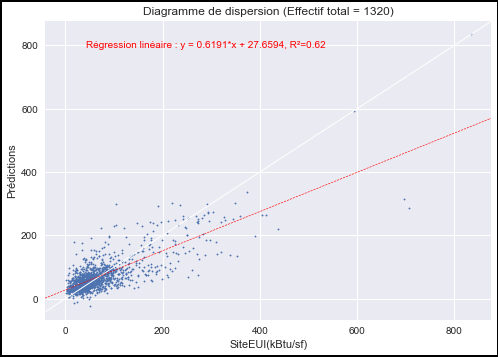

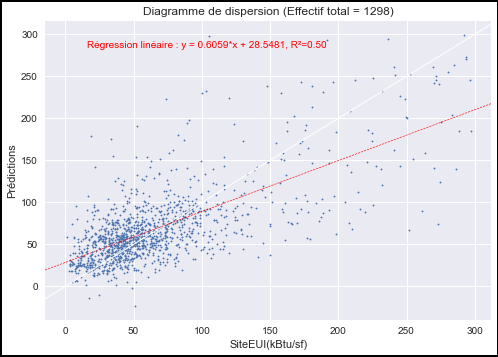

In [47]:
ser_predictions = pd.Series(np.squeeze(EUI_predictions), name='Prédictions')
scatter_plot(ser_x=y_train_EUI.reset_index().iloc[:,1], ser_y=ser_predictions, alpha=1, ligne_diagonale=True)
scatter_plot(ser_x=y_train_EUI.reset_index().iloc[:,1], ser_y=ser_predictions, alpha=1, max_x=300, max_y=300, ligne_diagonale=True)

### Analyse des paramètres du modèle

In [48]:
lin_reg.get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}

In [49]:
lin_reg.intercept_

array([106.38667152])

In [50]:
print("lin_reg.coef_ shape :", lin_reg.coef_.shape)
coefs = lin_reg.coef_

lin_reg.coef_ shape : (1, 241)


In [51]:
modalites_var_quali = full_pipeline.named_transformers_['quali'].named_steps['encoder'].get_feature_names(input_features=liste_variables_qualitatives)
modalites_var_quali

array(['BuildingType_Campus', 'BuildingType_NonResidential', 'BuildingType_Nonresidential COS', 'BuildingType_SPS-District K-12',
       'PrimaryPropertyType_Distribution Center', 'PrimaryPropertyType_Hospital', 'PrimaryPropertyType_Hotel', 'PrimaryPropertyType_K-12 School',
       'PrimaryPropertyType_Laboratory', 'PrimaryPropertyType_Large Office', 'PrimaryPropertyType_Low-Rise Multifamily', 'PrimaryPropertyType_Medical Office',
       'PrimaryPropertyType_Mixed Use Property', 'PrimaryPropertyType_Office', 'PrimaryPropertyType_Other', 'PrimaryPropertyType_Refrigerated Warehouse',
       'PrimaryPropertyType_Residence Hall', 'PrimaryPropertyType_Restaurant', 'PrimaryPropertyType_Retail Store', 'PrimaryPropertyType_Self-Storage Facility',
       'PrimaryPropertyType_Senior Care Community', 'PrimaryPropertyType_Small- and Mid-Sized Office', 'PrimaryPropertyType_Supermarket / Grocery Store',
       'PrimaryPropertyType_University', 'PrimaryPropertyType_Warehouse', 'PrimaryPropertyType_Wo

In [52]:
noms_des_coefs = np.concatenate([liste_variables_quantitatives, modalites_var_quali])

In [53]:
# inspiré de https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html#interpreting-coefficients-scale-matters
df_coefs = pd.DataFrame(coefs.T, columns=['Coefficients'], index=noms_des_coefs)
with pd.option_context('display.max_rows', 300, 'display.max_colwidth', None, 'display.max_columns', 100, 'display.precision', 1) :
    display(df_coefs.sort_values(by='Coefficients', ascending=False))

,Coefficients
ZipCode_98013.0,393.9
ZipCode_98185.0,367.6
LargestPropertyUseType_Data Center,367.6
PrimaryPropertyType_Laboratory,184.2
PrimaryPropertyType_Supermarket / Grocery Store,154.2
LargestPropertyUseType_Restaurant,152.6
SecondLargestPropertyUseType_Data Center,131.2
LargestPropertyUseType_Other/Specialty Hospital,105.8
ThirdLargestPropertyUseType_Strip Mall,97.5
ThirdLargestPropertyUseType_Other - Recreation,95.9


In [54]:
df_coefs.loc[liste_variables_quantitatives]

,Coefficients
Latitude,5.504705
Longitude,6.462588
YearBuilt,-1.182663
NumberofBuildings,-1.682082
NumberofFloors,-0.685633
Surface_au_sol(sf),1.256171


### Cross validation

In [55]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [56]:
lin_scores = cross_val_score(lin_reg, X_train_EUI_prepared, y_train_EUI,
                             scoring="neg_root_mean_squared_error", cv=10)
display_scores(-lin_scores)

Scores: [52.62286817 60.75858195 57.3318761  72.17653255 46.97996595 94.15059091 53.84549718 60.49324153 53.31428876 54.28321432]
Mean: 60.595665742053896
Standard deviation: 12.876808165324956


In [57]:
lin_scores = cross_val_score(lin_reg, X_train_EUI_prepared, y_train_EUI,
                             scoring="neg_median_absolute_error", cv=10)
display_scores(-lin_scores)

Scores: [21.40836219 28.90093059 21.2238699  24.83934074 23.37216731 20.54193669 21.47506928 18.07005765 24.40574351 22.14051985]
Mean: 22.637799771541573
Standard deviation: 2.7947337111389623


C'est pas terrible. On passe de RMSE=44 (validation sur le jeu d'entraînement) à 60 (validation croisée) en moyenne.

## Régression linéaire avec transformation de y_train

### Transformation = QuantileTransformer

In [58]:
transformer = QuantileTransformer(output_distribution='normal')
regressor = LinearRegression()
regr_ttr = TransformedTargetRegressor(regressor=regressor, transformer=transformer)

# Entrainement
regr_ttr.fit(X_train_EUI_prepared, y_train_EUI)

TransformedTargetRegressor(regressor=LinearRegression(),
                           transformer=QuantileTransformer(output_distribution='normal'))

In [59]:
# Test de quelques valeurs prédites
some_data_predicted_ttr = regr_ttr.predict(some_data_prepared)

some_labels['Prédictions_ttr'] = some_data_predicted_ttr
some_labels.head(20)

,SiteEUI(kBtu/sf),Prédictions,Prédictions_ttr
3162,42.799999,59.230377,53.377343
953,37.599998,28.567644,32.000000
2637,55.400002,74.624596,73.542116
29,92.900002,75.240507,70.252179
1126,36.799999,27.209902,37.327752
773,45.500000,78.520747,56.000000
305,89.300003,193.994349,172.881348
2928,35.000000,75.721566,46.405772
579,104.099998,92.325513,85.926674
713,40.200001,21.662289,32.428055


##### RMSE :

In [60]:
EUI_predictions = regr_ttr.predict(X_train_EUI_prepared)
lin_mse = mean_squared_error(y_train_EUI, EUI_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

46.28090815019097

##### R²

In [61]:
#R² par la méthode score() du transformateur
regr_ttr.score(X_train_EUI_prepared, y_train_EUI)

0.5812790800110295

In [62]:
#R² par la fonction r2_score de metrics
r2_score(y_train_EUI, EUI_predictions)

0.5812790800110295

##### Scatter plot :

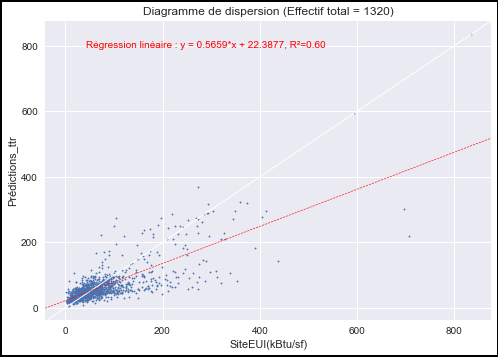

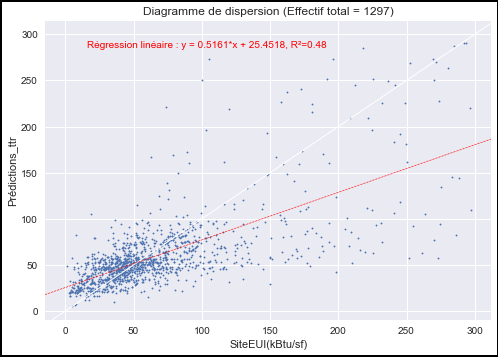

In [63]:
ser_predictions = pd.Series(np.squeeze(EUI_predictions), name='Prédictions_ttr')
scatter_plot(ser_x=y_train_EUI.reset_index().iloc[:,1], ser_y=ser_predictions, alpha=1, ligne_diagonale=True)
scatter_plot(ser_x=y_train_EUI.reset_index().iloc[:,1], ser_y=ser_predictions, alpha=1, max_x=300, max_y=300, ligne_diagonale=True)

Il n'y a pas eu d'amélioration par l'ajout d'une transformation de y_train.

### Transformation = fonction log

In [64]:
regressor = LinearRegression()
regr_ttr2 = TransformedTargetRegressor(regressor=regressor, func=np.log, inverse_func=np.exp)

# Entrainement
regr_ttr2.fit(X_train_EUI_prepared, y_train_EUI)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=LinearRegression())

In [65]:
# Test de quelques valeurs prédites
some_data_predicted_ttr = regr_ttr2.predict(some_data_prepared)

some_labels['Prédictions_ttr2'] = some_data_predicted_ttr
some_labels.head(20)

,SiteEUI(kBtu/sf),Prédictions,Prédictions_ttr,Prédictions_ttr2
3162,42.799999,59.230377,53.377343,56.714187
953,37.599998,28.567644,32.000000,31.113047
2637,55.400002,74.624596,73.542116,78.030090
29,92.900002,75.240507,70.252179,70.563247
1126,36.799999,27.209902,37.327752,35.053509
773,45.500000,78.520747,56.000000,56.132265
305,89.300003,193.994349,172.881348,151.302783
2928,35.000000,75.721566,46.405772,49.095230
579,104.099998,92.325513,85.926674,87.038591
713,40.200001,21.662289,32.428055,30.479381


##### RMSE :

In [66]:
EUI_predictions = regr_ttr2.predict(X_train_EUI_prepared)
lin_mse = mean_squared_error(y_train_EUI, EUI_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

45.66865325114479

##### R²

In [67]:
#R² par la méthode score() du transformateur
regr_ttr2.score(X_train_EUI_prepared, y_train_EUI)

0.5922844043372848

In [68]:
#R² par la fonction r2_score de metrics
r2_score(y_train_EUI, EUI_predictions)

0.5922844043372848

##### Scatter plot :

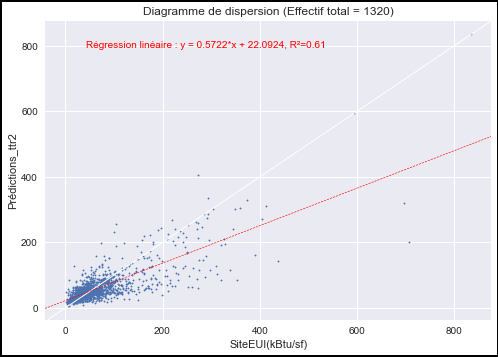

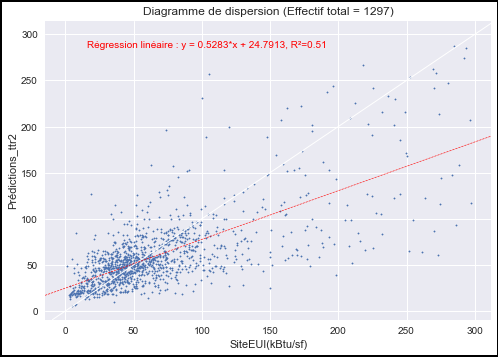

In [69]:
ser_predictions = pd.Series(np.squeeze(EUI_predictions), name='Prédictions_ttr2')
scatter_plot(ser_x=y_train_EUI.reset_index().iloc[:,1], ser_y=ser_predictions, alpha=1, ligne_diagonale=True)
scatter_plot(ser_x=y_train_EUI.reset_index().iloc[:,1], ser_y=ser_predictions, alpha=1, max_x=300, max_y=300, ligne_diagonale=True)

Il n'y a pas eu d'amélioration par l'ajout d'une transformation de y_train.

# Arbres de décision

In [70]:
tree_reg = DecisionTreeRegressor(random_state=0)
tree_reg.fit(X_train_EUI_prepared, y_train_EUI)

DecisionTreeRegressor(random_state=0)

In [71]:
EUI_predictions = tree_reg.predict(X_train_EUI_prepared)
tree_mse = mean_squared_error(y_train_EUI, EUI_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse  

0.0

In [72]:
print("R² =", r2_score(y_train_EUI, EUI_predictions))

R² = 1.0


RMSE = 0 et R² = 1 car car test sur jeu d'entrainement d'un arbre totalement ajusté

In [73]:
scores = cross_val_score(tree_reg, X_train_EUI_prepared, y_train_EUI, 
                         scoring="neg_root_mean_squared_error", cv=10)

In [74]:
display_scores(-scores)

Scores: [ 64.11670423  84.39107383  69.20897896  84.67409897  51.95283699 106.86545881  77.48951836  76.60078531  51.853283    65.95979965]
Mean: 73.31125381101012
Standard deviation: 15.741915405876721


La RMSE en validation croisée passe de 60 (rég linéaire) à 74 (arbres de décision).

# Forêts aléatoires

In [75]:
forest_reg = RandomForestRegressor(n_estimators=20, max_features=80, random_state=0)
forest_reg.fit(X_train_EUI_prepared, y_train_EUI.iloc[:,0])

RandomForestRegressor(max_features=80, n_estimators=20, random_state=0)

In [76]:
forest_predictions = forest_reg.predict(X_train_EUI_prepared)
forest_mse = mean_squared_error(y_train_EUI, forest_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse     # attention : test sur jeu d'entrainement

22.967151568519512

In [77]:
forest_scores = cross_val_score(forest_reg, X_train_EUI_prepared, y_train_EUI.iloc[:,0],
                                scoring="neg_root_mean_squared_error", cv=10)
display_scores(-forest_scores)

Scores: [44.47442349 55.32639454 51.3524506  67.5114764  43.32567263 92.95330298 53.63921025 60.18207867 45.12558108 54.44586544]
Mean: 56.83364560662592
Standard deviation: 13.96557703608069


RMSE moyen = 59. C'est un peu mieux que la rég. linéaire (RMSE moyen = 60).

## GridSearchCV

In [78]:
param_grid = [
#     {'n_estimators': [10], 'max_features': [10], 'random_state': [0]},
    {'n_estimators': [20, 40, 80], 'max_features': [40, 80, 160], 'random_state': [0]},
#     {'n_estimators': [5, 20], 'max_features': [20, 40, 80], 'random_state': [0], 'bootstrap': [False]},
            ]
grid_search = GridSearchCV(forest_reg, param_grid, cv=10,
                           scoring='neg_root_mean_squared_error', return_train_score=True)
grid_search.fit(X_train_EUI_prepared, y_train_EUI.iloc[:,0])

GridSearchCV(cv=10,
             estimator=RandomForestRegressor(max_features=80, n_estimators=20,
                                             random_state=0),
             param_grid=[{'max_features': [40, 80, 160],
                          'n_estimators': [20, 40, 80], 'random_state': [0]}],
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [79]:
grid_search.best_params_

{'max_features': 40, 'n_estimators': 80, 'random_state': 0}

In [80]:
grid_search.best_estimator_

RandomForestRegressor(max_features=40, n_estimators=80, random_state=0)

In [81]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print("RMSE =", -mean_score, params)

RMSE = 56.993831741078544 {'max_features': 40, 'n_estimators': 20, 'random_state': 0}
RMSE = 56.20857423777562 {'max_features': 40, 'n_estimators': 40, 'random_state': 0}
RMSE = 55.99102129812145 {'max_features': 40, 'n_estimators': 80, 'random_state': 0}
RMSE = 56.83364560662592 {'max_features': 80, 'n_estimators': 20, 'random_state': 0}
RMSE = 56.30523702851773 {'max_features': 80, 'n_estimators': 40, 'random_state': 0}
RMSE = 56.230337474627774 {'max_features': 80, 'n_estimators': 80, 'random_state': 0}
RMSE = 57.93796455551093 {'max_features': 160, 'n_estimators': 20, 'random_state': 0}
RMSE = 57.60985745417221 {'max_features': 160, 'n_estimators': 40, 'random_state': 0}
RMSE = 57.2497091349518 {'max_features': 160, 'n_estimators': 80, 'random_state': 0}


In [82]:
with pd.option_context('display.max_rows', 400, 'display.max_colwidth', 1000):
    display(pd.DataFrame(grid_search.cv_results_))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.146208,0.003219,0.0023,4.583856e-04,40,20,0,"{'max_features': 40, 'n_estimators': 20, 'random_state': 0}",-48.118491,-51.523587,-46.601248,-69.572939,-44.543003,-93.813895,-50.589578,-61.229250,-47.439334,-56.506991,-56.993832,14.269386,6,-24.308359,-24.576242,-25.241266,-24.185702,-25.758852,-23.069327,-24.572225,-23.686633,-22.586489,-23.141357,-24.112645,0.948478
1,0.287716,0.003822,0.0036,4.899112e-04,40,40,0,"{'max_features': 40, 'n_estimators': 40, 'random_state': 0}",-46.620732,-52.745712,-46.905704,-69.144311,-41.895802,-92.642112,-50.631011,-60.607002,-46.869735,-54.023622,-56.208574,14.256564,2,-22.359829,-22.570839,-22.803337,-21.990241,-23.709917,-21.757685,-23.328792,-22.569730,-22.306510,-22.415666,-22.581255,0.553331
2,0.576433,0.007392,0.0073,6.403628e-04,40,80,0,"{'max_features': 40, 'n_estimators': 80, 'random_state': 0}",-46.944132,-53.757904,-46.440415,-68.861421,-41.265003,-91.921656,-50.266276,-59.834107,-47.051207,-53.568092,-55.991021,14.088624,1,-21.851315,-21.722251,-21.970176,-21.045705,-22.269915,-20.117120,-22.165651,-21.855810,-21.959268,-21.576528,-21.653374,0.604701
3,0.216212,0.002522,0.0023,4.582972e-04,80,20,0,"{'max_features': 80, 'n_estimators': 20, 'random_state': 0}",-44.474423,-55.326395,-51.352451,-67.511476,-43.325673,-92.953303,-53.639210,-60.182079,-45.125581,-54.445865,-56.833646,13.965577,5,-24.059166,-23.884604,-26.013383,-23.416430,-25.743202,-23.309124,-24.421587,-23.350091,-23.058843,-23.718455,-24.097489,0.969395
4,0.433125,0.002809,0.0039,2.999942e-04,80,40,0,"{'max_features': 80, 'n_estimators': 40, 'random_state': 0}",-45.448710,-54.284958,-48.462706,-68.005123,-41.736739,-92.530066,-52.670098,-60.455064,-45.695876,-53.763032,-56.305237,14.121878,4,-22.495925,-22.270466,-23.318876,-22.046557,-23.800377,-21.745736,-23.365197,-22.826858,-23.022138,-23.001315,-22.789344,0.610812
5,0.864149,0.007190,0.0070,1.283923e-07,80,80,0,"{'max_features': 80, 'n_estimators': 80, 'random_state': 0}",-46.326168,-53.688488,-47.342139,-67.197300,-42.059228,-92.455727,-53.721054,-60.730452,-45.747000,-53.035818,-56.230337,14.012780,3,-22.017977,-21.792972,-22.428976,-21.279678,-22.773797,-20.182282,-22.258134,-22.007916,-22.353692,-21.975448,-21.907087,0.689565
6,0.349620,0.004005,0.0023,4.582452e-04,160,20,0,"{'max_features': 160, 'n_estimators': 20, 'random_state': 0}",-45.640184,-56.447616,-51.322130,-69.871566,-44.581440,-92.042751,-55.344596,-62.580830,-47.252413,-54.296118,-57.937965,13.553213,9,-24.609845,-25.108602,-26.001483,-24.011411,-25.952811,-23.010170,-25.043381,-23.974042,-23.763290,-23.748044,-24.522308,0.942390
7,0.703740,0.006915,0.0040,4.471812e-04,160,40,0,"{'max_features': 160, 'n_estimators': 40, 'random_state': 0}",-46.330886,-55.715711,-50.691160,-68.883296,-43.850414,-92.683574,-55.190476,-62.517532,-46.638258,-53.597267,-57.609857,13.753782,8,-22.561024,-22.951013,-23.857694,-22.272301,-24.260243,-21.919814,-23.765126,-23.001448,-23.062160,-23.168937,-23.081976,0.690357
8,1.414381,0.018906,0.0073,4.582192e-04,160,80,0,"{'max_features': 160, 'n_estimators': 80, 'random_state': 0}",-46.707093,-55.136820,-49.705545,-68.546766,-43.037650,-92.010077,-56.460681,-62.073463,-45.499947,-53.319049,-57.249709,13.739770,7,-21.991577,-22.135549,-22.905872,-21.619492,-23.108867,-20.340638,-22.621043,-22.248837,-22.609990,-22.371577,-22.195344,0.744519


# SVM Regressor

In [83]:
svm_reg = SVR(kernel="linear")
svm_reg.fit(X_train_EUI_prepared, y_train_EUI.iloc[:,0])

SVR(kernel='linear')

In [85]:
SVR_predictions = svm_reg.predict(X_train_EUI_prepared)
svm_mse = mean_squared_error(y_train_EUI, SVR_predictions)
svm_rmse = np.sqrt(svm_mse)
print("RMSE = ", svm_rmse)

RMSE =  64.67004836227653


C'est mauvais.